# imports

In [336]:
# system imports
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from numpyro.infer import MCMC, NUTS

# relative imports
os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')
from core import models, distributions, utils, metrics
from core.hmc import hmc_sampler
from core.nuts import nuts
from core.rwmh import rwmh_sampler
from core.sgd import train_sgd

In [7]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# dataset

In [409]:
# define x
step = 0.05
x_true = jnp.linspace(-2, 2, 500)[:, None]
x_train = jnp.concatenate([jnp.arange(-1.5, 0, step), jnp.arange(1, 1.5, step)])[:, None]
x_test = jnp.linspace(-2, 2, 100)[:, None]
N, C = x_train.shape

# define true model
key = jax.random.PRNGKey(7568)
layer_dims = 3*[10]
stdev = 1
predict_fn, params_true = models.make_nn(key, x_train, layer_dims, stdev)

# generate y
y_true = predict_fn(x_true, params_true)[:, 0]
y_train = predict_fn(x_train, params_true)[:, 0]
y_test = predict_fn(x_test, params_true)[:, 0]

# standardize y
mean, sd = y_true.mean(), y_true.std()
y_true = (y_true - mean) / sd
y_train = (y_train - mean) / sd
y_test = (y_test - mean) / sd

# add noise
key, train_noise_key, test_noise_key = jax.random.split(key, 3)
sigma_obs = 0.3
y_train += sigma_obs * jax.random.normal(train_noise_key, [N])
y_test += sigma_obs * jax.random.normal(test_noise_key, [len(y_test)])

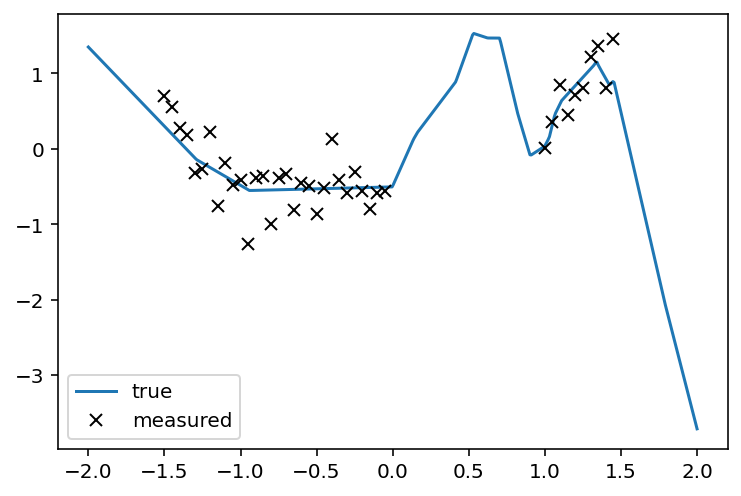

In [410]:
fig, ax = plt.subplots()
ax.plot(x_true[:, 0], y_true, label='true')
# ax.plot(x_test[:, 0], y_test, 'x', c='black', label='measured')
ax.plot(x_train[:, 0], y_train, 'x', c='black', label='measured')
ax.legend()
plt.show()

# model

In [411]:
# define model
# - when using a large NN with a small dataset, the prior must be very flat so that it doesn't dominate the likelihood
layer_dims = 3*[10]
init_sd = 0.1
prior_sd = 1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
params_init = jax.tree_map(lambda x: init_sd*x, params_init)
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [412]:
# TEST: NN params shape
print(jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print(log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

FlatMap({
  'linear': FlatMap({'b': (10,), 'w': (1, 10)}),
  'linear_1': FlatMap({'b': (10,), 'w': (10, 10)}),
  'linear_2': FlatMap({'b': (10,), 'w': (10, 10)}),
  'linear_3': FlatMap({'b': (2,), 'w': (10, 2)}),
})
-242.0414 -41.245087 -283.2865


# training

In [263]:
# create multiple chains using each method to allow cmputing r_hat
n_chains = 3

# number of samples to keep from each chain
n_samples = 100

# stdev for sampling the initial params in each chain
init_sd = 0.1

## SGD

In [269]:
%%time
key = jax.random.PRNGKey(0)
chains_sgd = []
for i in range(n_chains):
    key, init_key = jax.random.split(key, 2)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    params, log_prob_sgd = train_sgd(params_start, log_likelihood_fn)
    chains_sgd += [[params]]

CPU times: user 2.46 s, sys: 56.5 ms, total: 2.52 s
Wall time: 2.59 s


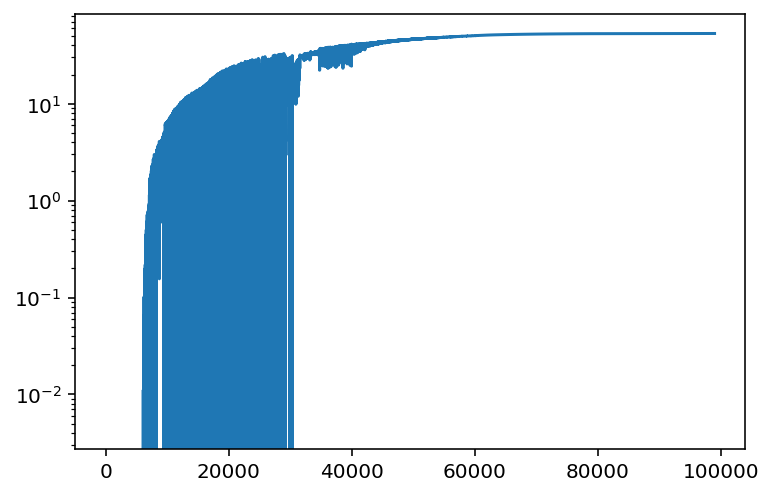

In [270]:
fig, ax = plt.subplots()
ax.plot(-log_prob_sgd[1000:])
plt.yscale('log')
plt.show()

## RWMH

In [271]:
%%time
key = jax.random.PRNGKey(0)
n_blind_steps = 10_000
step_size = 1e-3
chains_rwmh = []
for i in range(n_chains):
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    chain = rwmh_sampler(params_start, log_posterior_fn, mcmc_key, n_samples, n_blind_steps, step_size)
    chains_rwmh += [chain]

Avg. accept. prob.: 92.80%
Avg. accept. prob.: 93.79%
Avg. accept. prob.: 95.07%
CPU times: user 25.9 s, sys: 224 ms, total: 26.1 s
Wall time: 26.3 s


## HMC

In [272]:
%%time
step_size = 1e-4
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
chains_hmc = []
for i in range(n_chains):
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    chain = hmc_sampler(params_start, log_posterior_fn, n_samples, n_leapfrog_steps, step_size, key)
    chains_hmc += [chain]

Avg. accept. prob.: 99.06%
Avg. accept. prob.: 99.12%
Avg. accept. prob.: 98.98%
CPU times: user 39.7 s, sys: 464 ms, total: 40.1 s
Wall time: 40.5 s


## NUTS

In [260]:
%%time
# actually, NUTS never decets a U-turn, it reaches the max. num. of steps
# - given this reality, HMC makes more sense
n_steps = 10
step_size = 1e-4
max_leapfrog_steps = 2 ** 14
print(f'{max_leapfrog_steps=}')
key = jax.random.PRNGKey(0)
chain = nuts(params_init, log_posterior_fn, step_size, key, n_steps, max_leapfrog_steps)

max_leapfrog_steps=16384
16384.00 steps, 100.00% valid, 99.90% acceptance.
Termination: max_steps=10, u-turn=0, max_error=0.
CPU times: user 5.78 s, sys: 47.8 ms, total: 5.83 s
Wall time: 5.85 s


## combined training

In [277]:
%%time
# TODO: sometimes, the acceptance rate is very small... why?
n_outer_steps = 10
n_inner_steps = 10
step_size = 1e-4
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
chains_mixed = []
for i in range(n_chains):
    chain_outer = []
    for j in range(n_outer_steps):
        key, init_key, mcmc_key = jax.random.split(key, 3)
        params_start = utils.normal_like_tree(params_init, init_key)
        params_start = jax.tree_map(lambda x: init_sd*x, params_start)
        params_sgd, log_prob_sgd = train_sgd(params_start, log_likelihood_fn)
        chain_inner = hmc_sampler(params_sgd, log_posterior_fn, n_inner_steps, n_leapfrog_steps, step_size, mcmc_key)
        chain_outer += chain_inner
    chains_mixed += [chain_outer]

Avg. accept. prob.: 98.06%
Avg. accept. prob.: 82.86%
Avg. accept. prob.: 98.36%
Avg. accept. prob.: 87.96%
Avg. accept. prob.: 99.60%
Avg. accept. prob.: 99.53%
Avg. accept. prob.: 89.51%
Avg. accept. prob.: 10.00%
Avg. accept. prob.: 98.68%
Avg. accept. prob.: 98.20%
Avg. accept. prob.: 98.88%
Avg. accept. prob.: 98.61%
Avg. accept. prob.: 83.69%
Avg. accept. prob.: 89.65%
Avg. accept. prob.: 94.63%
Avg. accept. prob.: 10.00%
Avg. accept. prob.: 97.77%
Avg. accept. prob.: 0.17%
Avg. accept. prob.: 98.76%
Avg. accept. prob.: 21.97%
Avg. accept. prob.: 88.23%
Avg. accept. prob.: 98.42%
Avg. accept. prob.: 51.87%
Avg. accept. prob.: 83.07%
Avg. accept. prob.: 89.53%
Avg. accept. prob.: 99.61%
Avg. accept. prob.: 93.49%
Avg. accept. prob.: 45.86%
Avg. accept. prob.: 99.68%
Avg. accept. prob.: 96.43%
CPU times: user 2min 17s, sys: 1.92 s, total: 2min 19s
Wall time: 2min 20s


## numpyro

In [313]:
%%time
potential_fn = lambda x: -log_posterior_fn(x)
nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=n_samples)
chains_numpyro = []
for i in range(n_chains):
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    mcmc.run(mcmc_key, init_params=params_start)
    chain = mcmc.get_samples()
    chains_numpyro += [chain]
    # TODO: numpyro seems to return just the last node, not the full history
    print(len(chain))

sample: 100%|█| 200/200 [00:04<00:00, 41.77it/s, 1023 steps of size 1.96e-03. 


4


sample: 100%|█| 200/200 [00:02<00:00, 99.75it/s, 1023 steps of size 2.38e-03. 


4


sample: 100%|█| 200/200 [00:02<00:00, 99.13it/s, 1023 steps of size 1.92e-03. 

4
CPU times: user 8.8 s, sys: 151 ms, total: 8.96 s
Wall time: 9.04 s


In [308]:
len(chains_numpyro[0])

4

In [307]:
len(chains_rwmh[0])

100

## create chains dict

In [314]:
chains_dict = {
    'sgd': chains_sgd,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'mixed': chains_mixed,
    # 'numpyro': chains_numpyro,
}

# predictions

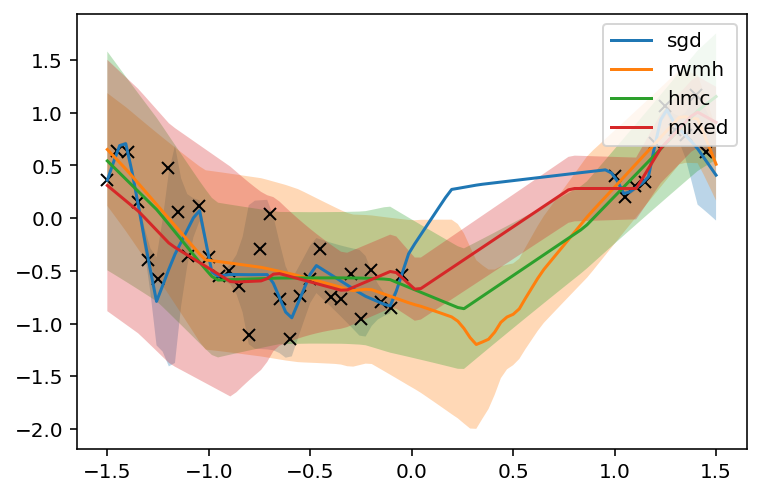

In [316]:
fig, ax = plt.subplots()

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')

# plot predictions
x_full = jnp.linspace(-1.5, 1.5, 100)[:, None]
for i, (name, chains) in enumerate(chains_dict.items()):
    y_hat = predict_fn(x_full, chains[-1][-1])
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=name)

ax.legend(loc='upper right')
plt.show()

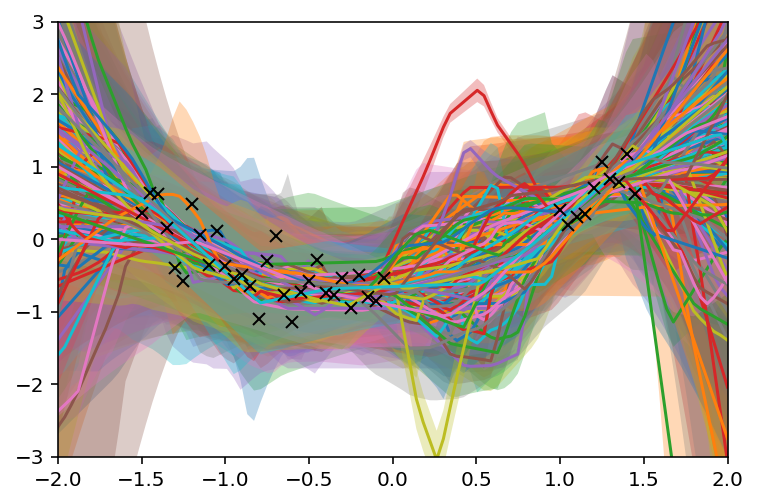

In [317]:
fig, ax = plt.subplots()

# plot predictions
x_full = jnp.linspace(-2, 2, 100)[:, None]
for i, params in enumerate(params_hmc):
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=i)

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')
ax.set_xlim([-2, 2])
ax.set_ylim([-3, 3])

# ax.legend()
plt.show()

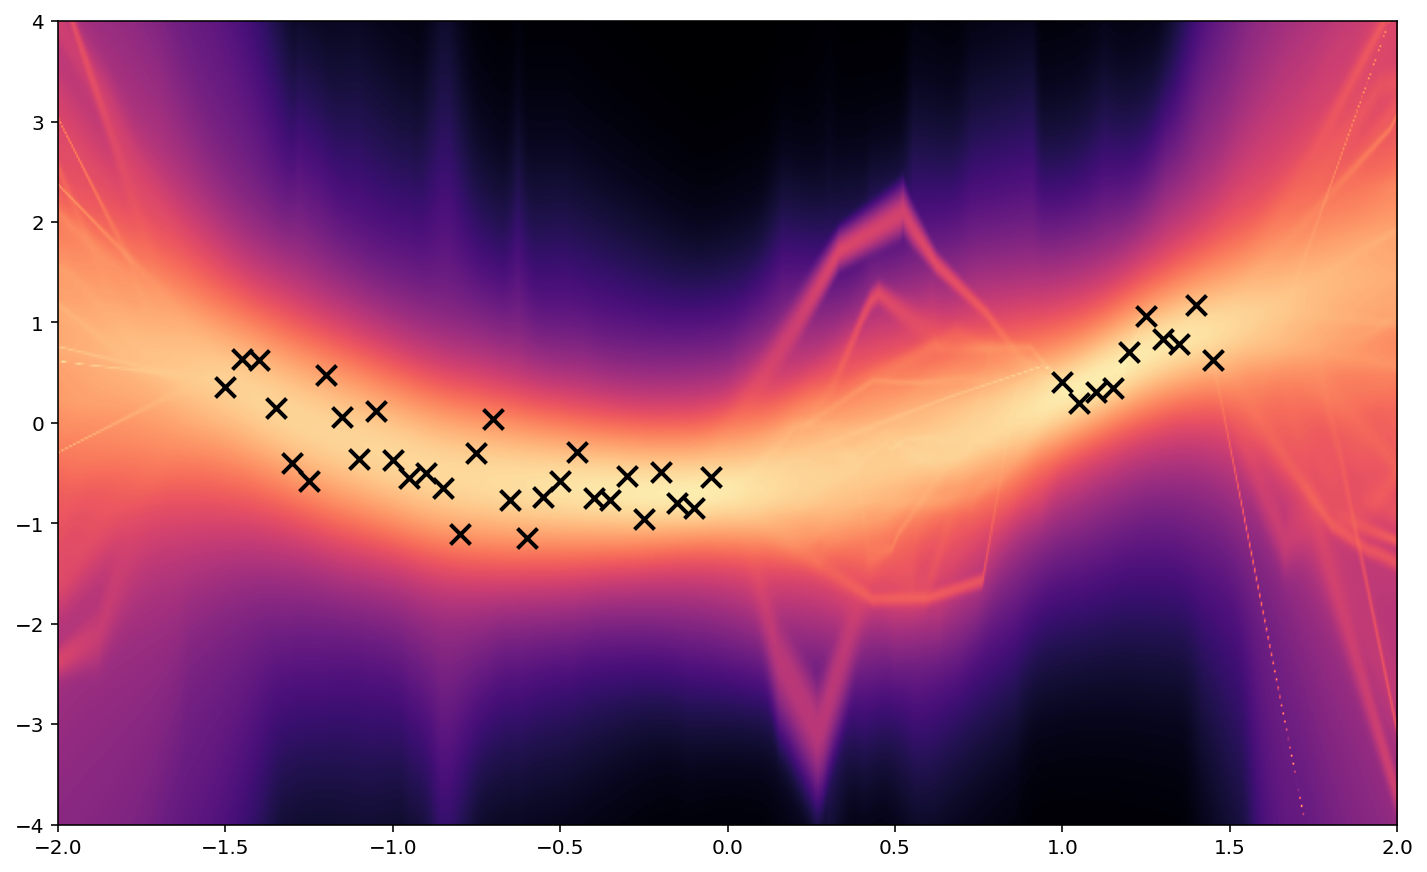

In [324]:
# create grid to evaluate posterior predictive density
nx, ny = 800, 400
x_full = jnp.linspace(-2, 2, nx)
y_full = jnp.linspace(-4, 4, ny)
z_full = jnp.zeros([nx, ny])

# average over posterior samples
for params in params_hmc:
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
    log_prob = jnp.nan_to_num(log_prob)
    z_full += jnp.exp(log_prob) # / len(params_hmc)

# density plot
fig, ax = plt.subplots(figsize=[12, 8])
extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
ax.imshow(z_full.T**(1/8), origin='lower', cmap='magma', extent=extent, aspect=0.3, label='predicted')
# ax.plot(x_true[:, 0], y_true, label='true', lw=4, c='green')
ax.scatter(x_train[:, 0], y_train, marker='x', color='black', s=100, linewidth=2, label='observed')
# ax.legend()
plt.show()

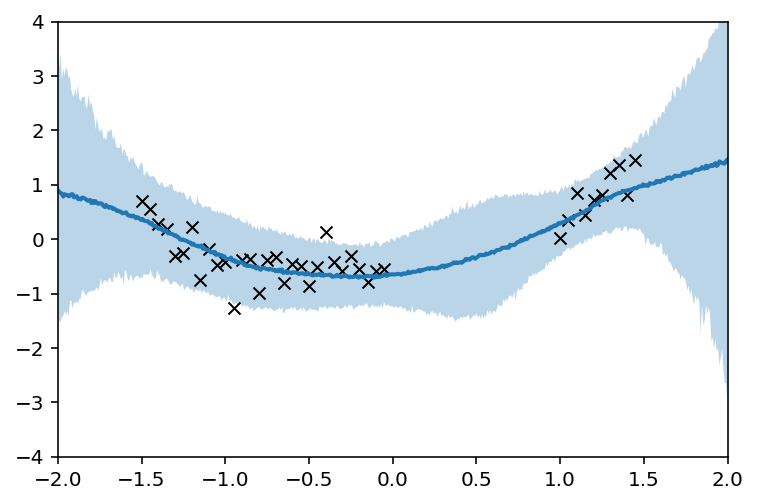

In [413]:
key = jax.random.PRNGKey(0)
alpha = 0.05
used_steps = len(params_hmc) - warmup_steps
nx = 500
x_full = jnp.linspace(-2, 2, nx)
n_samples = 1_000
n_samples_per_step = n_samples // used_steps

samples = jnp.zeros([nx, used_steps, n_samples_per_step])
for i, params in enumerate(params_hmc):
    key, _ = jax.random.split(key)
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    current_samples = mean[:, None] + std[:, None] * jax.random.normal(key, [nx, n_samples_per_step])
    samples = samples.at[:, i, :].set(current_samples)

# flatten sampled predictions across posterior samples
samples = samples.reshape([nx, used_steps*n_samples_per_step])

# get posterior predictive quntiles
quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    
# CI plot
fig, ax = plt.subplots()
ax.fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3)
ax.plot(x_full, quantiles[1, :], label='predicted', lw=2)
# ax.plot(x_true[:, 0], y_true, label='true', c='red')
ax.scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, label='observed')
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.legend()
plt.show()

# diagnostics

In [342]:
def chains_to_arr(chains):
    # maps a pytree chain to an nd array
    return jnp.array([[utils.ravel_pytree_(node) for node in chain] for chain in chains])

## history of a single parameter

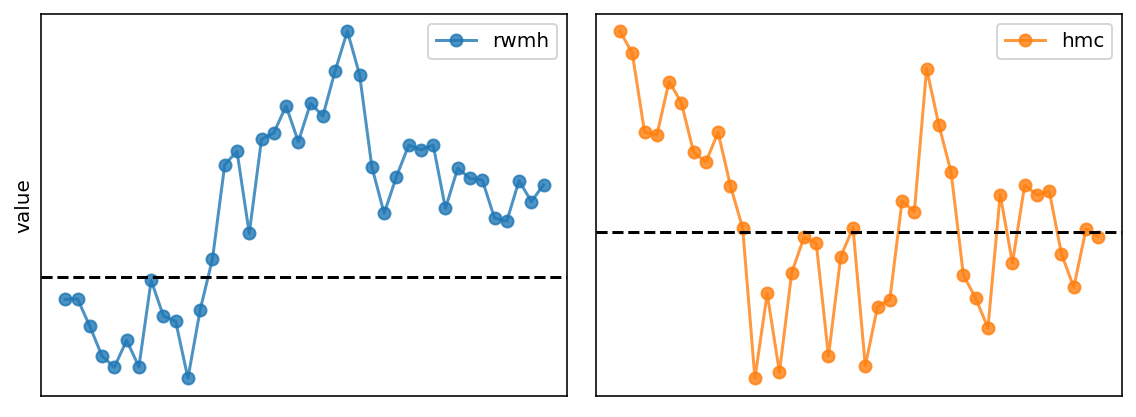

In [345]:
chain_idx = 0
param_idx = 0
n_points = 40
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    param = chains[chain_idx, :, param_idx]
    line, = axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    axs[i].axhline(y=chains_arr[:, :, param_idx].mean(), linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
    if i in [2, 3]: axs[i].set_xlabel('step')
    if i in [0, 2]: axs[i].set_ylabel('value')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

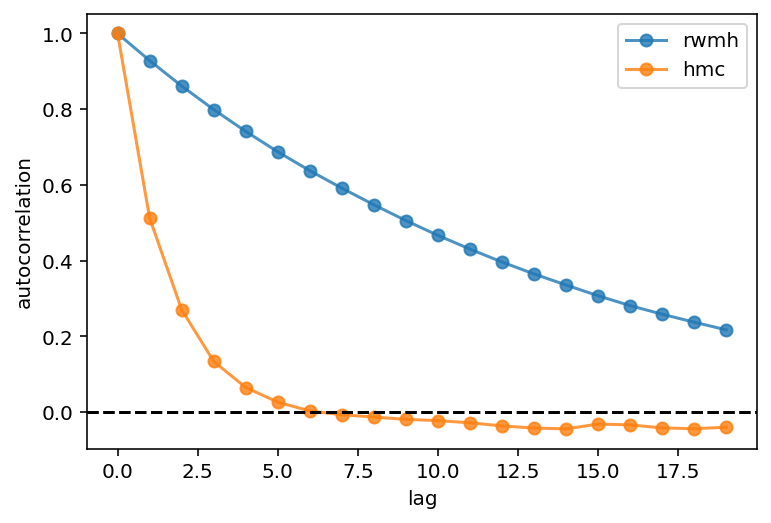

In [347]:
fig, ax = plt.subplots()

# autocorrelation
f = lambda x: x
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    r = metrics.autocorr(chains, f)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

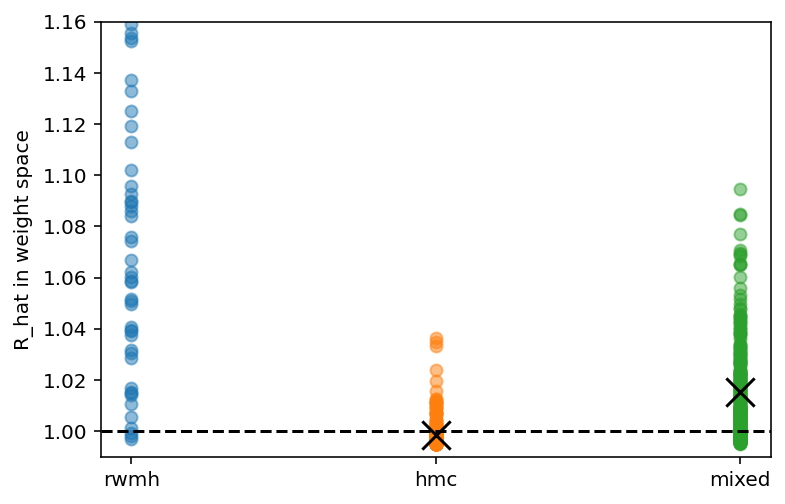

In [368]:
fig, ax = plt.subplots()

# R_hat
f = lambda x: x
chains_to_show = ['rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    r = metrics.r_hat(chains, f)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)), chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
ax.set_ylim([0.99, 1.16])
plt.show()

## Likelihood of test data

In [454]:
# create unravel function
params_tree = chains_dict['hmc'][0][-1]
unravel_fn = ravel_pytree(params_tree)[1]

# function like 'predict_fn' but takes in an array an unravels it
def predict_from_array(x, params_flat):
    params_tree = unravel_fn(params_flat)
    y_hat = predict_fn(x, params_tree)
    return y_hat


def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    predict_vmap = jax.vmap(predict_from_array, [None, 0])
    y_hat = predict_vmap(x_test, chain)
    mean, std = y_hat[:, :, 0], y_hat[:, :, 1]

    # compute likelihood for each node in the chain
    log_likelihood = distributions.gaussian_log_pdf(y_test[None, :], mean, std)

    # average the likelihood across nodes
    log_likelihood = log_likelihood.mean(0)

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood

for i, (name, chains) in enumerate(chains_dict.items()):
    chains = chains_to_arr(chains)
    
    # compute likelihood for each chain
    loss_fn_vmap = jax.vmap(chain_to_loglike, 0)
    loss = loss_fn_vmap(chains)
    
    # ll = chain_to_loglike(chains)
    print(f'{name}: {loss.mean():.3f} ± {loss.std():.4f}')

sgd: -284679936.000 ± 402574784.0000
rwmh: -1642.749 ± 586.0688
hmc: -22698.109 ± 12213.9375
mixed: -6024236303212609536.000 ± 8519556501973499904.0000


## Distribution of parameters

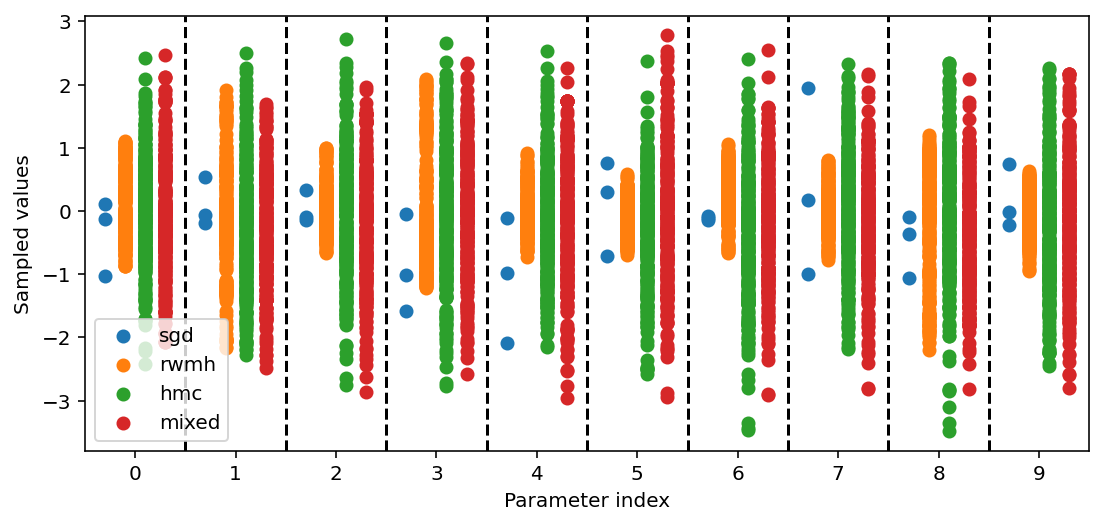

In [373]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(10), range(10))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()